In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import plotnine as pn
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=True, figsize=(2,2), transparent=True, format="pdf")

-----
anndata     0.7.5
scanpy      1.8.1
sinfo       0.3.1
-----
PIL                 8.1.1
adjustText          NA
anndata             0.7.5
anyio               NA
argon2              20.1.0
asciitree           NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2021.10.08
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.3.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
descartes           NA
fasteners           NA
future_fstrings     NA
google              NA
h5py                2.10.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_serv

In [3]:
Mock_Ileum_D1PI_sc = sc.read_10x_h5('./../scData/Ileum_Mock_D1PI/outs/filtered_feature_bc_matrix.h5')
T1L_Ileum_D1PI_sc = sc.read_10x_h5('./../scData/Ileum_T1L-WT_D1PI/outs/filtered_feature_bc_matrix.h5')
Mock_Ileum_D4PI_sc = sc.read_10x_h5('./../scData/Ileum_Mock_D4PI/outs/filtered_feature_bc_matrix.h5')
T1L_Ileum_D4PI_sc = sc.read_10x_h5('./../scData/Ileum_T1L-WT_D4PI/outs/filtered_feature_bc_matrix.h5')
Mock_Ileum_D1PI_sc.var_names_make_unique()
T1L_Ileum_D1PI_sc.var_names_make_unique()
Mock_Ileum_D4PI_sc.var_names_make_unique()
T1L_Ileum_D4PI_sc.var_names_make_unique()

reading ./../scData/Ileum_Mock_D1PI/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./../scData/Ileum_T1L-WT_D1PI/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./../scData/Ileum_Mock_D4PI/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./../scData/Ileum_T1L-WT_D4PI/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
samples = ["Ileum_Mock_D1PI", "Ileum_T1L-WT_D1PI", "Ileum_Mock_D4PI", "Ileum_T1L-WT_D4PI",]

In [5]:
ileum_infection_sc = Mock_Ileum_D1PI_sc.concatenate(T1L_Ileum_D1PI_sc, Mock_Ileum_D4PI_sc, 
                                                    T1L_Ileum_D4PI_sc,
                                                    batch_key= "sample", batch_categories=samples,
                                                    index_unique="-")

In [6]:
ileum_infection_sc.obs_names_make_unique()
ileum_infection_sc.var_names_make_unique()

In [7]:
print(ileum_infection_sc.shape)

(24901, 54848)


In [8]:
reoviral_genes = [name for name in ileum_infection_sc.var_names if name.startswith('Reo')]
viral_expression = ileum_infection_sc[:,reoviral_genes].to_df()

viral_expression.columns = [x.split("_")[1] for x in viral_expression.columns]
print(reoviral_genes)
reoviral_genes_indicator = np.in1d(ileum_infection_sc.var_names, reoviral_genes)
ileum_infection_sc = ileum_infection_sc[:, ~reoviral_genes_indicator]
ileum_infection_sc.var_names = [name.split("_")[1] for name in ileum_infection_sc.var_names]
ileum_infection_sc.obs = ileum_infection_sc.obs.join(viral_expression.astype(int))
print(ileum_infection_sc.shape)

['ReoT1L_T1LReoS1', 'ReoT1L_T1LReoS2', 'ReoT1L_T1LReoS3', 'ReoT1L_T1LReoS4', 'ReoT1L_T1LReoM1', 'ReoT1L_T1LReoM2', 'ReoT1L_T1LReoM3', 'ReoT1L_T1LReoL1', 'ReoT1L_T1LReoL2', 'ReoT1L_T1LReoL3']
(24901, 54838)


In [9]:
sc.pp.filter_cells(ileum_infection_sc, min_counts=1)
sc.pp.filter_genes(ileum_infection_sc, min_cells=1)

filtered out 178 cells that have less than 1 counts
filtered out 25313 genes that are detected in less than 1 cells


In [11]:
ileum_infection_sc.var['mt'] = ileum_infection_sc.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(ileum_infection_sc, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


In [14]:
ileum_infection_sc.obs['total_viral'] = viral_expression.sum(axis=1).astype(int)
ileum_infection_sc.obs['pct_viral'] = ileum_infection_sc.obs['total_viral'] / ileum_infection_sc.obs['total_counts']


In [15]:
ileum_infection_sc.obs["stage"] = [x.split("_")[2] for x in ileum_infection_sc.obs["sample"]]
ileum_infection_sc.obs["state"] = [x.split("_")[1] for x in ileum_infection_sc.obs["sample"]]
ileum_infection_sc.obs["stage"] = ileum_infection_sc.obs["stage"].astype("category")
ileum_infection_sc.obs["state"] = ileum_infection_sc.obs["state"].astype("category")
ileum_infection_sc.obs["stage"].cat.reorder_categories(new_categories=["D1PI", "D4PI"], inplace = True)
ileum_infection_sc.obs["state"].cat.reorder_categories(new_categories=["Mock", "T1L-WT"], inplace = True)
ileum_infection_sc.obs["condition"] = [ileum_infection_sc.obs["state"][i] + "_" + ileum_infection_sc.obs["stage"][i] for i in range(ileum_infection_sc.shape[0])]
ileum_infection_sc.obs["condition"] = ileum_infection_sc.obs["condition"].astype("category")
ileum_infection_sc.obs["condition"].cat.reorder_categories(new_categories=["Mock_D1PI", "T1L-WT_D1PI", "Mock_D4PI", "T1L-WT_D4PI"], inplace = True)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


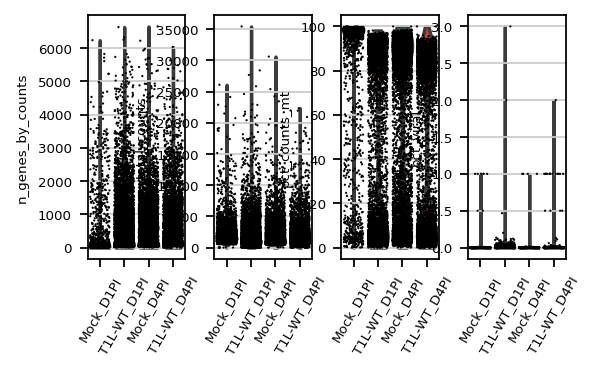

In [16]:
sc.pl.violin(ileum_infection_sc, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_viral'],
             jitter=0.4, multi_panel=True, stripplot=True, groupby = "condition", rotation= 60)

In [17]:
ileum_infection_sc = ileum_infection_sc[ileum_infection_sc.obs.pct_counts_mt < 30, :]

In [18]:
sc.pp.filter_cells(ileum_infection_sc, min_genes=200)
sc.pp.filter_genes(ileum_infection_sc, min_cells=10)


filtered out 875 cells that have less than 200 genes expressed


Trying to set attribute `.obs` of view, copying.


filtered out 10465 genes that are detected in less than 10 cells


In [19]:
ileum_infection_sc.obs["sample"].value_counts()

Ileum_T1L-WT_D1PI    3109
Ileum_T1L-WT_D4PI    2303
Ileum_Mock_D4PI      2013
Ileum_Mock_D1PI       270
Name: sample, dtype: int64

In [20]:
# ileum_infection_sc.write_h5ad("./../pyobjs_github/ileum_infection_sc_raw_counts.h5ad")

In [21]:
sc.pp.normalize_total(ileum_infection_sc, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [22]:
sc.pp.log1p(ileum_infection_sc)

In [23]:
sc.pp.highly_variable_genes(ileum_infection_sc, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


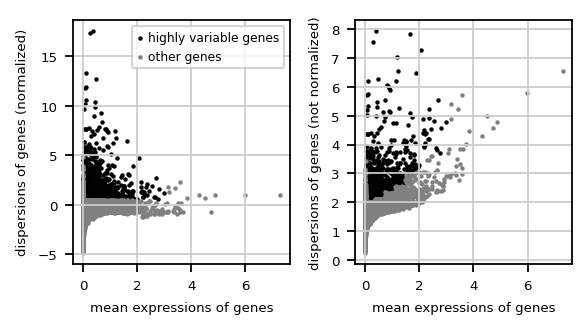

In [24]:
sc.pl.highly_variable_genes(ileum_infection_sc, )

In [25]:
s_genes = list(pd.read_csv("./../s.genes.txt")["x"])
g2m_genes = list(pd.read_csv("./../g2m.genes.txt")["x"])
print(s_genes)
print(g2m_genes)

['Mcm4', 'Exo1', 'Slbp', 'Gmnn', 'Cdc45', 'Msh2', 'Mcm6', 'Rrm2', 'Pold3', 'Blm', 'Ubr7', 'Mcm5', 'Clspn', 'Hells', 'Nasp', 'Rpa2', 'Rad51ap1', 'Tyms', 'Rrm1', 'Rfc2', 'Prim1', 'Brip1', 'Usp1', 'Ung', 'Pola1', 'Mcm2', 'Fen1', 'Tipin', 'Pcna', 'Cdca7', 'Uhrf1', 'Casp8ap2', 'Cdc6', 'Dscc1', 'Wdr76', 'E2f8', 'Dtl', 'Ccne2', 'Atad2', 'Gins2', 'Chaf1b', 'Pcna-ps2']
['Nuf2', 'Psrc1', 'Ncapd2', 'Ccnb2', 'Smc4', 'Lbr', 'Tacc3', 'Cenpa', 'Kif23', 'Cdca2', 'Anp32e', 'G2e3', 'Cdca3', 'Anln', 'Cenpe', 'Gas2l3', 'Tubb4b', 'Cenpf', 'Dlgap5', 'Hjurp', 'Cks1brt', 'Gtse1', 'Bub1', 'Birc5', 'Ube2c', 'Rangap1', 'Hmmr', 'Ect2', 'Tpx2', 'Ckap5', 'Cbx5', 'Nek2', 'Ttk', 'Cdca8', 'Nusap1', 'Ctcf', 'Cdc20', 'Cks2', 'Mki67', 'Tmpo', 'Ckap2l', 'Aurkb', 'Kif2c', 'Cdk1', 'Kif20b', 'Top2a', 'Aurka', 'Ckap2', 'Hmgb2', 'Cdc25c', 'Ndc80', 'Kif11']


In [26]:
sc.tl.score_genes_cell_cycle(ileum_infection_sc, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    671 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    629 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [27]:
ileum_infection_sc.raw = ileum_infection_sc
ileum_infection_sc = ileum_infection_sc[:, ileum_infection_sc.var.highly_variable]


In [28]:
ileum_infection_sc.X.shape

(7695, 3393)

In [29]:
sc.pp.regress_out(ileum_infection_sc, ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score'], n_jobs=20 )

regressing out ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score']
    sparse input is densified and may lead to high memory use


/home/mm2937/miniconda3/envs/python385/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'phase' as categorical


    finished (0:00:09)


In [30]:
sc.pp.scale(ileum_infection_sc, max_value=10)

In [31]:
sc.tl.pca(ileum_infection_sc)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


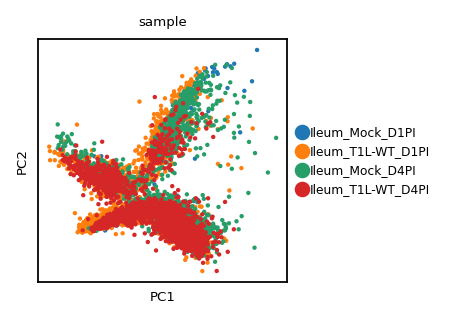

In [39]:
sc.pl.pca(ileum_infection_sc, color = ["sample"])

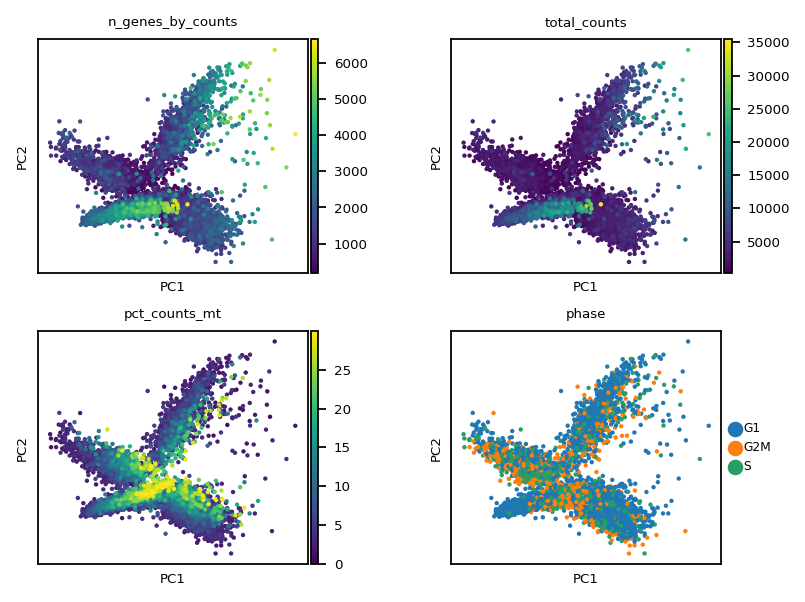

In [40]:
sc.pl.pca(ileum_infection_sc, color = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'phase'], ncols=2)

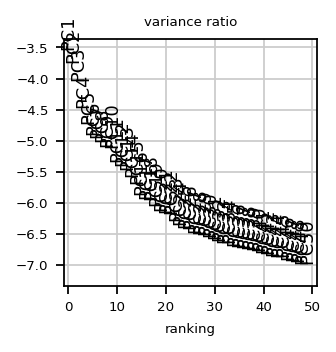

In [41]:
sc.pl.pca_variance_ratio(ileum_infection_sc, n_pcs = 50, log=True)

In [42]:
sc.pp.neighbors(ileum_infection_sc, n_pcs=20)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [43]:
sc.tl.umap(ileum_infection_sc)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)


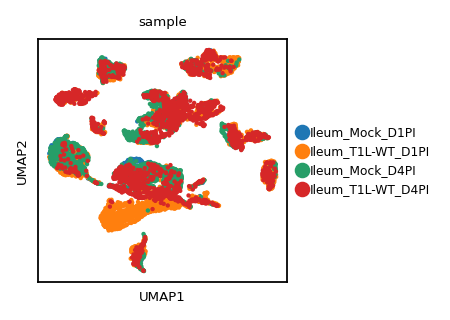

In [44]:
sc.pl.umap(ileum_infection_sc, color = 'sample')

In [45]:
sc.tl.embedding_density(ileum_infection_sc, groupby = "condition")

computing density on 'umap'
--> added
    'umap_density_condition', densities (adata.obs)
    'umap_density_condition_params', parameter (adata.uns)


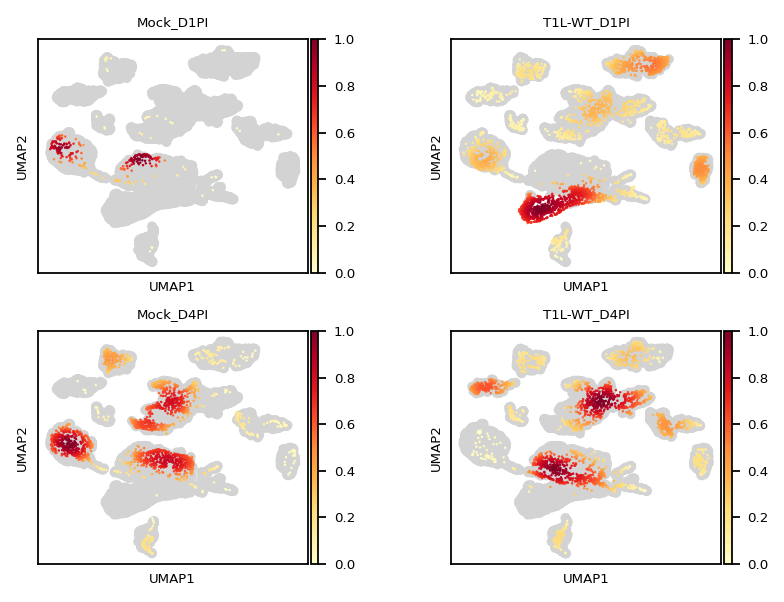

In [47]:
sc.pl.embedding_density(ileum_infection_sc, groupby = "condition", fg_dotsize= 5, ncols=2)

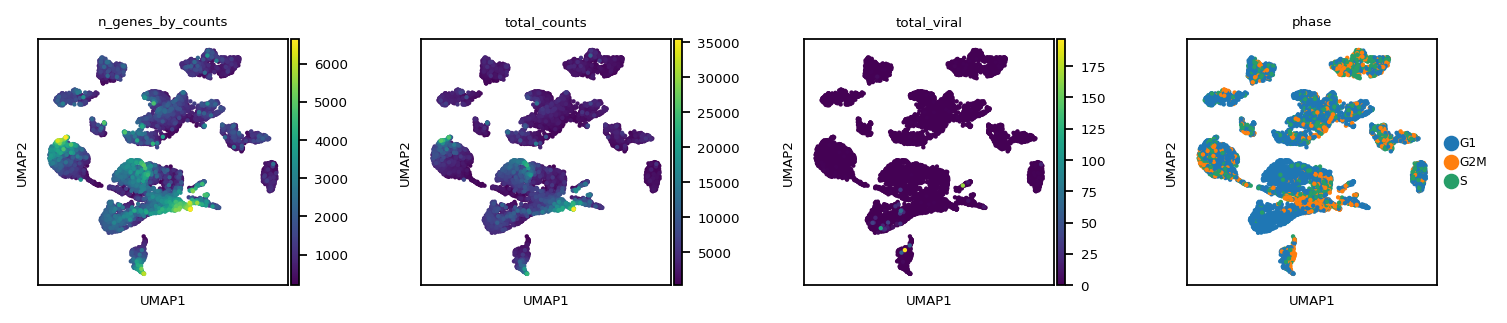

In [48]:
sc.pl.umap(ileum_infection_sc, color = ['n_genes_by_counts', 'total_counts', 'total_viral', "phase"])

In [49]:
sc.tl.leiden(ileum_infection_sc, key_added="leiden_0.5", resolution = 0.5)
sc.tl.leiden(ileum_infection_sc, key_added="leiden_0.3", resolution = 0.3)

running Leiden clustering
    finished: found 20 clusters and added
    'leiden_0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_0.3', the cluster labels (adata.obs, categorical) (0:00:00)


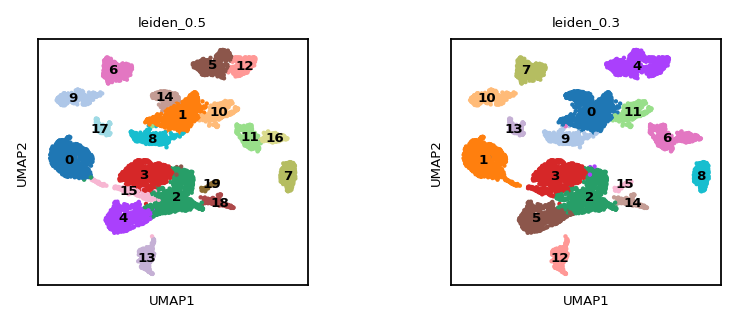

In [51]:
sc.pl.umap(ileum_infection_sc, color = ['leiden_0.5', "leiden_0.3"], legend_loc="on data")

In [53]:
sc.tl.rank_genes_groups(ileum_infection_sc, 'leiden_0.5', method='wilcoxon', key_added='rank_genes_groups_leiden_0.5')
sc.tl.rank_genes_groups(ileum_infection_sc, 'leiden_0.3', method='wilcoxon', key_added='rank_genes_groups_leiden_0.3')

ranking genes
    finished: added to `.uns['rank_genes_groups_leiden_0.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:15)
ranking genes
    finished: added to `.uns['rank_genes_groups_leiden_0.3']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)


In [54]:
sc.tl.dendrogram(ileum_infection_sc, "leiden_0.5", n_pcs=20)

    using 'X_pca' with n_pcs = 20
Storing dendrogram info using `.uns['dendrogram_leiden_0.5']`


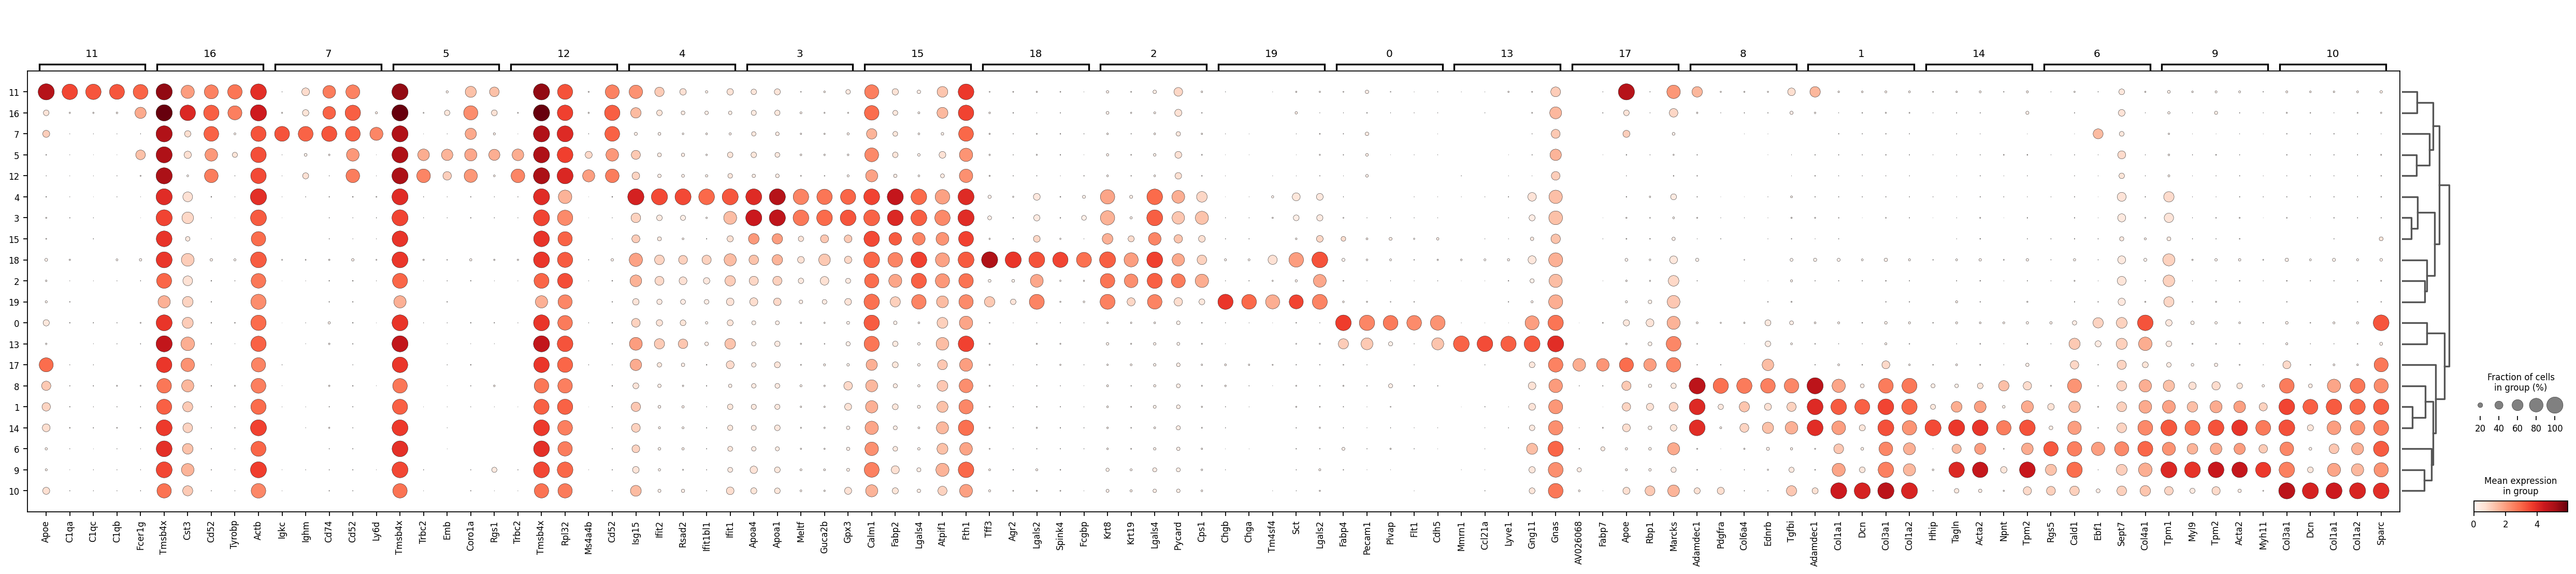

In [55]:
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=9, facecolor='white', frameon=True, figsize=(3, 3), transparent=True, format="pdf")
sc.pl.rank_genes_groups_dotplot(ileum_infection_sc, key= "rank_genes_groups_leiden_0.5", n_genes=5)
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=True, figsize=(3, 3), transparent=True, format="pdf")

In [56]:
pd.DataFrame(ileum_infection_sc.uns['rank_genes_groups_leiden_0.5']['names']).head(20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Fabp4,Adamdec1,Krt8,Apoa4,Isg15,Tmsb4x,Rgs5,Igkc,Adamdec1,Tpm1,Col3a1,Apoe,Trbc2,Mmrn1,Hhip,Calm1,Tmsb4x,AV026068,Tff3,Chgb
1,Pecam1,Col1a1,Krt19,Apoa1,Ifit2,Trbc2,Cald1,Ighm,Pdgfra,Myl9,Dcn,C1qa,Tmsb4x,Ccl21a,Tagln,Fabp2,Cst3,Fabp7,Agr2,Chga
2,Plvap,Dcn,Lgals4,Meltf,Rsad2,Emb,Ebf1,Cd74,Col6a4,Tpm2,Col1a1,C1qc,Rpl32,Lyve1,Acta2,Lgals4,Cd52,Apoe,Lgals2,Tm4sf4
3,Flt1,Col3a1,Pycard,Guca2b,Ifit1bl1,Coro1a,Sept7,Cd52,Ednrb,Acta2,Col1a2,C1qb,Ms4a4b,Gng11,Npnt,Atpif1,Tyrobp,Rbp1,Spink4,Sct
4,Cdh5,Col1a2,Cps1,Gpx3,Ifit1,Rgs1,Col4a1,Ly6d,Tgfbi,Myh11,Sparc,Fcer1g,Cd52,Gnas,Tpm2,Fth1,Actb,Marcks,Fcgbp,Lgals2
5,Cd93,Col6a1,Lypd8,Naga,Cmpk2,Junb,Pdgfrb,H2-Aa,Col4a5,Actg2,Lum,Ctss,Coro1a,Fgl2,Tpm1,Dbi,Coro1a,Tuba1a,Defa24,Neurod1
6,Ptprb,Col6a2,Lgals2,Spink1,Oasl1,Cd52,Itga1,H2-Eb1,Bmp5,Tagln,Dpt,Tyrobp,Cd3g,Cavin2,Myh11,Oat,Lsp1,Vim,Lypd8,Cck
7,Col4a1,Mdk,Mt1,Apoc3,Ifi27l2b,Rac2,Notch3,Rps24,Ptch1,Mylk,Col14a1,Aif1,Rpl8,Prss23,Frem2,Cystm1,Sh3bgrl3,Cryab,Muc2,Pcsk1
8,Igfbp7,Ifitm1,Aldh1b1,Folr1,Epcam,AW112010,Ndufa4l2,Cd79b,Lamb1,Dstn,Mdk,Psap,Cd3d,Cldn5,Adamdec1,Gm42418,Cd74,Tgfb2,Spint2,Krt20
9,Kdr,Zeb2,Epcam,Mamdc4,Apoa1,Srgn,Gucy1a1,Tmsb4x,Tmem176b,Myl6,Postn,Tmsb4x,Rps3,Reln,Myl9,Txndc17,Psap,Serpine2,Krt8,Sis


In [57]:
ileum_infection_sc.obs["celltypes_leiden_0.5"] = ileum_infection_sc.obs["leiden_0.5"]
celltypes = {'0': "Endothelial cells", 
             '1': "Fibroblasts-1", 
             '2': "Stem/TA", 
             '3': "Enterocytes",
             '4': "Inflamed enterocytes",
             '5': "T-cells",
             '6': "Axial mural cells", 
             '7': "B-cells",
             '8': "Fibroblasts-2",
             '9': "Smooth-muscle cells",
             '10': "Fibroblasts-3",
             '11': "Macrophages",
             '12': "T-cells",
             '13': "Lymphatic cells",
             '14': "Fibroblasts-4",
             '15': "Enterocytes",
             '16': "Dendritic cells",
             '17': "Enteric neurons",
             '18': "Goblet cells",
             '19': "Entero-endochrine cells"}
ileum_infection_sc.obs["celltypes_leiden_0.5"] = ileum_infection_sc.obs["celltypes_leiden_0.5"].map(celltypes).astype("category")

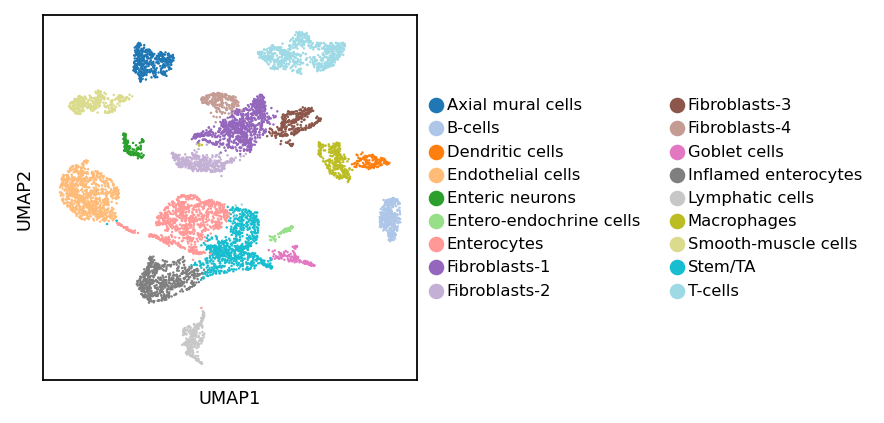

In [58]:
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=8, facecolor='white', frameon=True, figsize=(3.0, 3.0), transparent=True, format="pdf")
sc.pl.umap(ileum_infection_sc, color = ['celltypes_leiden_0.5'], size=5, palette="tab20", title="")

In [59]:
ileum_infection_sc.obs["celltype_groups"] = ileum_infection_sc.obs["leiden_0.5"]
celltypes = {'0': "Endothelial cells", 
             '1': "Fibroblasts", 
             '2': "Stem/TA", 
             '3': "Enterocytes",
             '4': "Enterocytes",
             '5': "T-cells",
             '6': "Axial mural cells", 
             '7': "B-cells",
             '8': "Fibroblasts",
             '9': "Smooth-muscle cells",
             '10': "Fibroblasts",
             '11': "Macrophages",
             '12': "T-cells",
             '13': "Lymphatic cells",
             '14': "Fibroblasts",
             '15': "Enterocytes",
             '16': "Dendritic cells",
             '17': "Enteric neurons",
             '18': "Goblet cells",
             '19': "Entero-endochrine cells"}
ileum_infection_sc.obs["celltype_groups"] = ileum_infection_sc.obs["celltype_groups"].map(celltypes).astype("category")

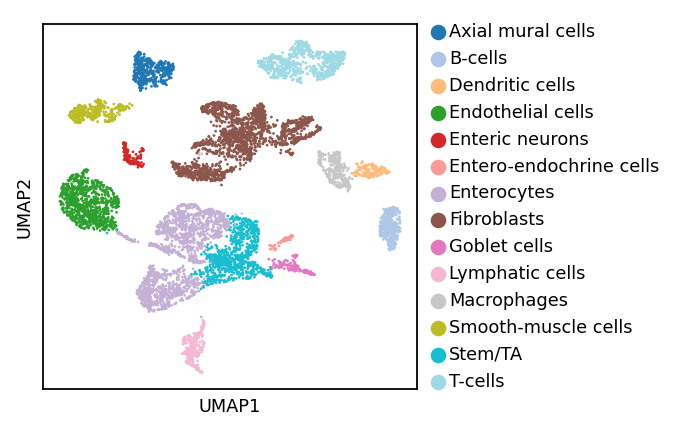

In [60]:
sc.pl.umap(ileum_infection_sc, color = ['celltype_groups'], size=6, palette="tab20", title="", legend_fontsize=8)

In [61]:
# ileum_infection_sc.write_h5ad(filename="./../pyobjs_github/ileum_infection_sc.h5ad")

In [3]:
ileum_infection_sc = sc.read_h5ad(filename="./../pyobjs_github/ileum_infection_sc.h5ad")

In [62]:
sc.tl.rank_genes_groups(ileum_infection_sc, groupby = 'condition', groups= ["T1L-WT_D1PI"],
                        reference= 'Mock_D1PI', key_added='rank_genes_T1L-WT_vs_Mock_D1PI',
                        method="wilcoxon")

ranking genes
    finished: added to `.uns['rank_genes_T1L-WT_vs_Mock_D1PI']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


In [63]:
sc.tl.rank_genes_groups(ileum_infection_sc, groupby = 'condition', groups= ["T1L-WT_D4PI"],
                        reference= 'Mock_D4PI', key_added='rank_genes_T1L-WT_vs_Mock_D4PI',
                        method="wilcoxon")

ranking genes
    finished: added to `.uns['rank_genes_T1L-WT_vs_Mock_D4PI']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


In [66]:
# This creates a new meta data varibale condition_new where all mocks have been merged into one sample

ileum_infection_sc.obs["condition_new"] = ileum_infection_sc.obs["condition"].map({"Mock_D1PI": "Mock", "Mock_D4PI": "Mock", "T1L-WT_D1PI": "T1L-WT_D1PI", "T1L-WT_D4PI": "T1L-WT_D4PI"}).astype("category")
ileum_infection_sc.obs["condition_new"].cat.reorder_categories(new_categories=["Mock", "T1L-WT_D1PI", "T1L-WT_D4PI"], inplace = True)

In [68]:
sc.tl.rank_genes_groups(ileum_infection_sc, groupby = 'condition_new', groups= ["T1L-WT_D1PI"],
                        reference= 'Mock', key_added='rank_genes_T1L-WT_vs_Mock-merged_D1PI',
                        method="wilcoxon")
sc.tl.rank_genes_groups(ileum_infection_sc, groupby = 'condition_new', groups= ["T1L-WT_D4PI"],
                        reference= 'Mock', key_added='rank_genes_T1L-WT_vs_Mock-merged_D4PI',
                        method="wilcoxon")

ranking genes
    finished: added to `.uns['rank_genes_T1L-WT_vs_Mock-merged_D1PI']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)
ranking genes
    finished: added to `.uns['rank_genes_T1L-WT_vs_Mock-merged_D4PI']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


In [69]:
# ileum_infection_sc.write_h5ad(filename="./../pyobjs/ileum_infection_sc.h5ad")

In [70]:
ileum_infection_sc = sc.read_h5ad(filename="./../pyobjs/ileum_infection_sc.h5ad")

In [95]:
sc.tl.rank_genes_groups(total_ileum, 'celltype_groups', method='wilcoxon', key_added='rank_genes_groups_celltypegroups')

ranking genes
    finished: added to `.uns['rank_genes_groups_celltypegroups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:25)


In [96]:
DGE_celltype_groups = pd.DataFrame(total_ileum.uns['rank_genes_groups_celltypegroups']['names']).head(200)
DGE_celltype_groups.to_csv("ileum_DGE_celltype_groups.csv")

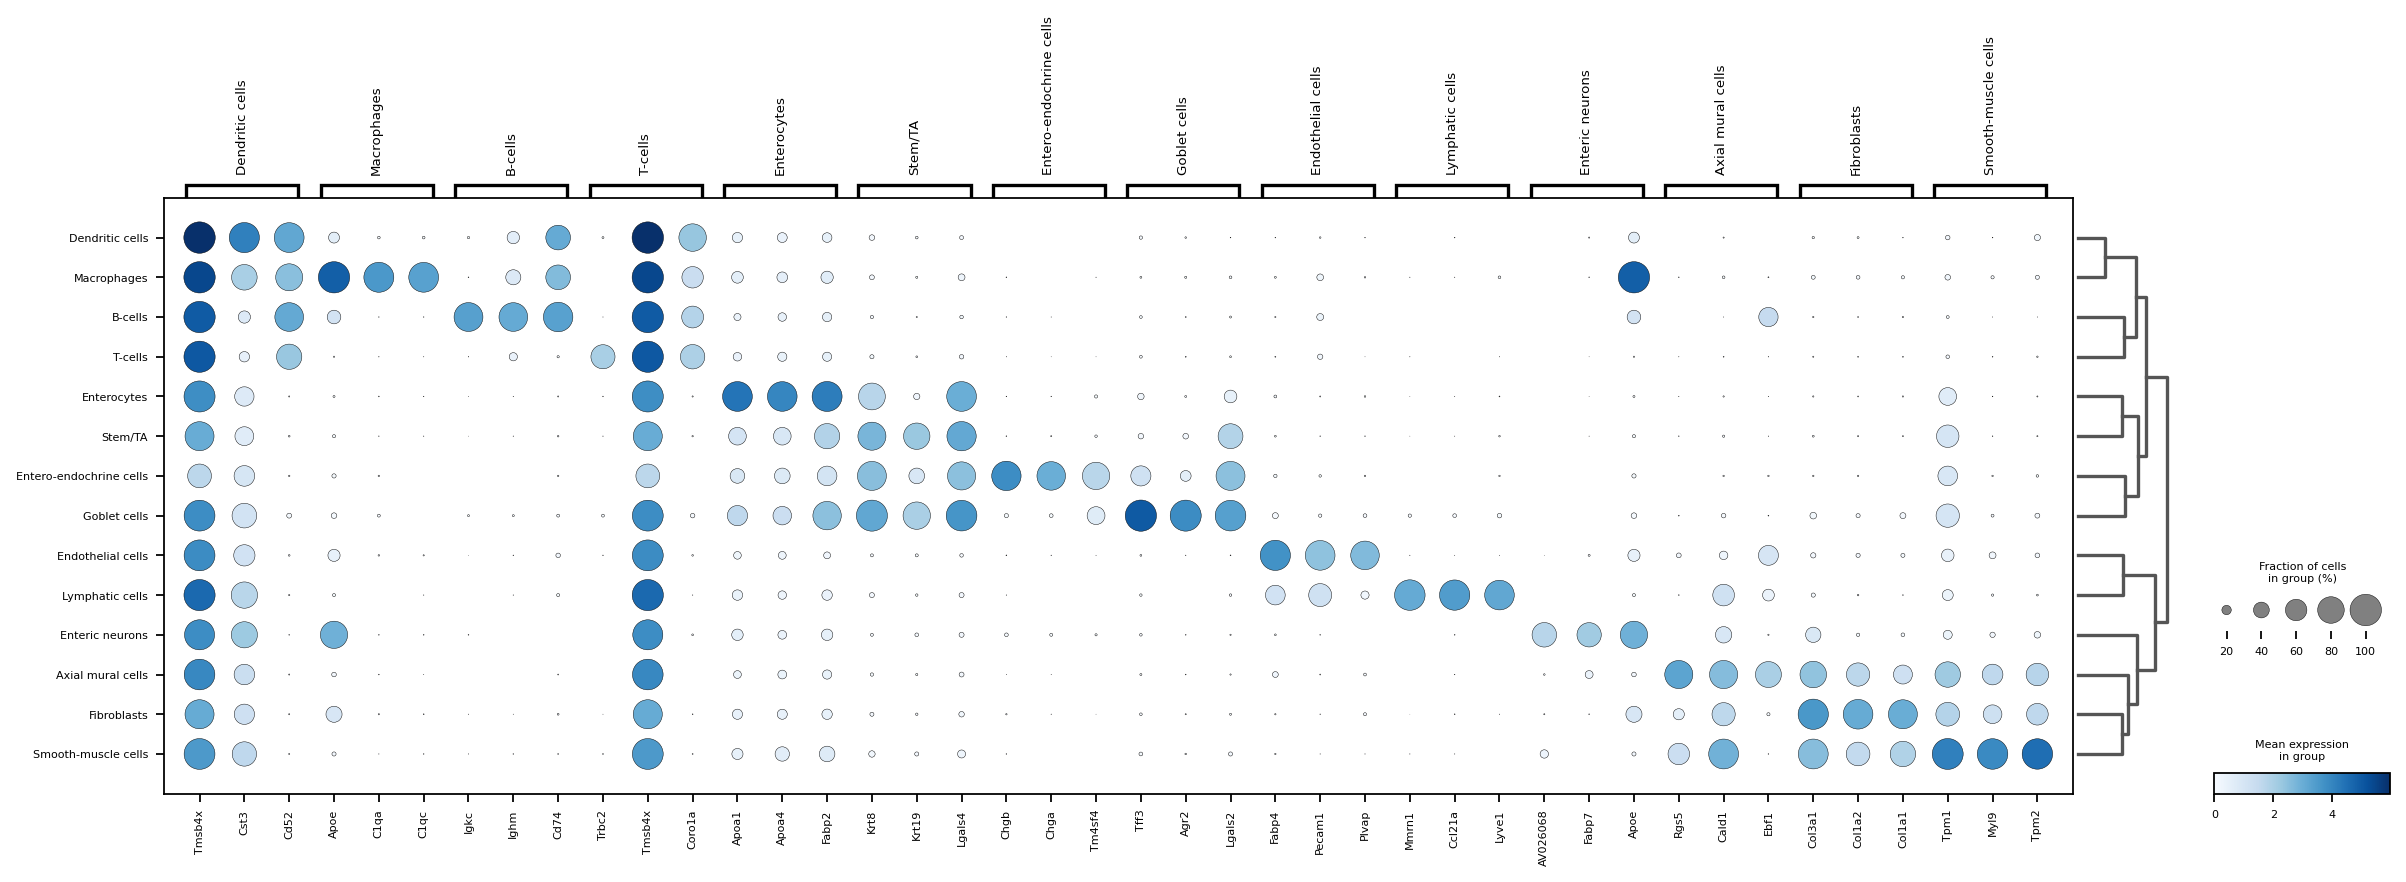

In [99]:
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, frameon=True, figsize=(3, 1), vector_friendly = False, transparent=True, format="pdf")
sc.pl.rank_genes_groups_dotplot(total_ileum, key= "rank_genes_groups_celltypegroups", n_genes=3, cmap='Blues', save="celltype_groups_markers_ileum.pdf")
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, frameon=True, figsize=(3, 3), transparent=True, format="pdf")

In [4]:
total_ileum

AnnData object with n_obs × n_vars = 7695 × 3393
    obs: 'sample', 'T1LReoS1', 'T1LReoS2', 'T1LReoS3', 'T1LReoS4', 'T1LReoM1', 'T1LReoM2', 'T1LReoM3', 'T1LReoL1', 'T1LReoL2', 'T1LReoL3', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_viral', 'pct_viral', 'stage', 'state', 'condition', 'n_genes', 'S_score', 'G2M_score', 'phase', 'umap_density_sample', 'leiden_0.5', 'leiden_0.3', 'celltypes_leiden_0.5', 'celltype_groups', 'condition_new'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_groups_colors', 'celltypes_leiden_0.5_colors', 'condition_colors', 'dendrogram_leiden_0.5', 'hvg', 'leiden', 'leiden_0.3_colors', 'leiden_0.5_colors', 'neighbors', 'pca', 'phase_colors', 'rank_genes_T1L-WT_vs_Mock-merged_D1PI', 'rank_genes_T1L-WT_vs_Mock-merged_D4PI', 'rank_g